# TFM - Daniel Cárdenas Hernández

# TAREA 3: Posibles cuaternas en N puntos de curva teórica I-V

## 3.1. Obtención curva teórica de forma directa 

#### Primera corrección: Usar función Lambert adecuada

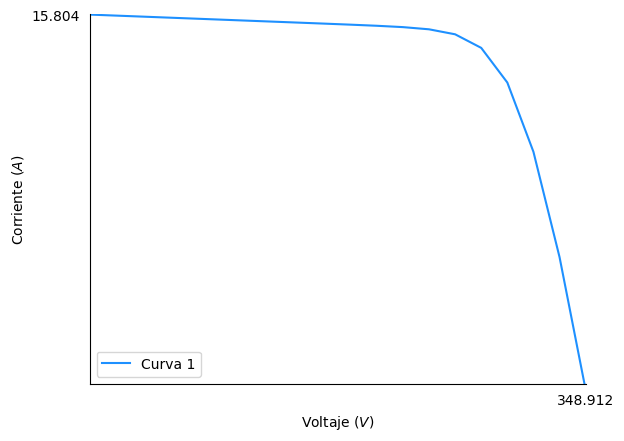

[  0.          18.36378288  36.72756576  55.09134863  73.45513151
  91.81891439 110.18269727 128.54648014 146.91026302 165.2740459
 183.63782878 202.00161165 220.36539453 238.72917741 257.09296029
 275.45674317 293.82052604 312.18430892 330.5480918  348.91187468]
348.9118746765349


In [3]:
# Importar librerías necesarias 
import numpy as np
import matplotlib.pyplot as plt
import math
import pvtools.singlediode.intensity  as intensity
from scipy.special import lambertw
from matplotlib.ticker import FormatStrFormatter

#np.set_printoptions(precision=100)

# Parámetros de entrada
Iph = 15.88
Isat = 7.440e-10
Rs = 2.04
Rsh = 425.2
at = 14.67
Voc = at*(math.log(Iph)-math.log(Isat))
DistV='Lineal' #['Lineal','MSP']

Vx=lambda x: (at*(Rs+Rsh)/Rsh)* (np.log(x)-Rs/at*((Rsh*(Iph+Isat))/(Rs+Rsh)-x) -np.log((Isat*Rsh)/(Rsh+Rs)));
Ix=lambda x: (Rsh*(Iph+Isat)-Vx(x))/(Rs+Rsh)-x;
    
    
if DistV=='MSP':
    Niter=6
    Isc = intensity.from_diode(Iph, Isat, at, Rsh, Rs, 0)
    xsc=(Isat*Rsh)/(Rsh+Rs)*math.exp((Isc*Rs)/at);
    xoc=(Isat*Rsh)/(Rsh+Rs)*np.exp(Voc/at);
    xMSP=(at/(Rsh+Rs))*(Isc*(Rsh+Rs)-Voc)/(Voc-Rs*Isc);
    
    
    n_puntos=2**Niter+1;
    print(n_puntos,'puntos')
    s=np.zeros((n_puntos,1))
    s[0]=xsc;s[n_puntos-1]=xoc;
    V_MSP=Vx(xMSP);I_MSP=Ix(xMSP);
    ids=[1,n_puntos];idnew=ids;
    for i in range(1,Niter+1):
                for k in range(1,2**(i-1)+1):
                     id=(2*k-1)*2**(Niter-i)
                     id1=(k-1)*2**(Niter-i+1)
                     id2=k*2**(Niter-i+1)
                     Idij=(Ix(s[id2])-Ix(s[id1]))/(Vx(s[id2])-Vx(s[id1]))
                     s[id]=-(at)/(Rs+Rsh)*(Idij*(Rs+Rsh)+1)/(1+Idij*Rs);
    
    V=np.zeros(s.shape);I=np.zeros(s.shape)
    V=Vx(s)
    I=Ix(s)
elif DistV=='Lineal':        
    n_puntos = 20
    V = np.linspace(0, Voc, n_puntos,dtype=np.float128)
    I = intensity.from_diode(Iph, Isat, at, Rsh, Rs, V)

# Gráfica de la curva teórica
plt.plot(V, I, label='Curva 1', color='dodgerblue')
plt.xlim(0,Voc+0.01)
plt.ylim(0,max(I)+0.02)
plt.xticks([Voc])  # Ejemplo de ticks en el eje x
plt.yticks([max(I)])  # Ejemplo de ticks en el eje y

# Ajustar la precisión de los ticks
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
#plt.scatter(V, I, s=13)
plt.xlabel(r'Voltaje $(V)$')
plt.ylabel(r'Corriente $(A)$')
plt.tick_params(left = False, bottom = False)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='lower left')
plt.savefig("Curva2.jpg")
plt.show()
print(V)
print(Voc)
V = V[:-1]
I = I[:-1]

## 3.2. Distribuciones de puntos. 

#### Segunda corrección: vectorizar todo el procedimiento posterior

In [4]:
from itertools import combinations

In [5]:
# Generar todas las combinaciones posibles de cuatro puntos de V
combinations_V = np.array(list(combinations(V, 4)),dtype=np.float128)

# Ordenar los voltajes dentro de cada combinación de menor a mayor
combinations_V = np.sort(combinations_V, axis=1)

# Obtener los valores correspondientes de I para cada combinación de voltajes
combinations_I = np.array([intensity.from_diode(Iph, Isat, at, Rsh, Rs, combination) for combination in combinations_V],dtype=np.float128)

In [6]:
# Definir los coeficientes
A = Iph * (Rsh / (Rsh + Rs))
B = Isat * (Rsh / (Rsh + Rs))
C = np.exp(1 / at)
D = np.exp(Rs / at)
E = 1 / (Rsh + Rs)

#Calculo de Alfas
# Función derivada
def I_derivada(I, V):
    return -(E + B * (C ** V) * (D ** I) * np.log(C)) / (1 + B * (C ** V) * (D ** I) * np.log(D))

### Polinomio grado 2 simplificado

$
\alpha = I'_1I'_2 + I'_3I'_4; \\
\beta = I'_1I'_3+I'_2I'_4;\\
\gamma = I'_1I'_4 + I'_2I'_3;\\
V_{ij} = V_i-V_j;\\
I_{ij} = I_i-I_j;\\
a = \alpha V_{12}V_{34}-\beta V_{13}V_{24}+\gamma V_{14}V_{23};\\
b = \alpha (V_{12}I_{34}+I_{12}V_{34})-\beta(V_{13}I_{24}+I_{13}V_{24})+\gamma(V_{14}I_{23}+I_{14}V_{23});\\
c = \alpha I_{12}I_{34}-\beta I_{13}I_{24}+\gamma I_{14}I_{23};\\
$

In [7]:
derivadas = I_derivada(combinations_I, combinations_V)

# Calcular alpha, beta y gamma
alpha = (derivadas[:, 0] * derivadas[:, 1]) + derivadas[:, 2] * derivadas[:, 3]
beta = (derivadas[:, 0] * derivadas[:, 2]) + derivadas[:, 1] * derivadas[:, 3]
gamma = (derivadas[:, 0] * derivadas[:, 3]) + derivadas[:, 1] * derivadas[:, 2]

# Calcular las diferencias de voltaje y corriente
V_diff = combinations_V[:, :, np.newaxis] - combinations_V[:, np.newaxis, :]
I_diff = combinations_I[:, :, np.newaxis] - combinations_I[:, np.newaxis, :]
V12, V13, V14, V23, V24, V34 = V_diff[:, 0, 1], V_diff[:, 0, 2], V_diff[:, 0, 3], V_diff[:, 1, 2], V_diff[:, 1, 3], V_diff[:, 2, 3]
I12, I13, I14, I23, I24, I34 = I_diff[:, 0, 1], I_diff[:, 0, 2], I_diff[:, 0, 3], I_diff[:, 1, 2], I_diff[:, 1, 3], I_diff[:, 2, 3]

# Calcular a, b, c
a = alpha * V12 * V34 - beta * V13 * V24 + gamma * V14 * V23
b = alpha * (V12 * I34 + I12 * V34) - beta * (V13 * I24 + I13 * V24) + gamma * (V14 * I23 + I14 * V23)
c = alpha * I12 * I34 - beta * I13 * I24 + gamma * I14 * I23


In [8]:
# Definición de discriminante
x_v = (b / (2 * a))
discriminante = x_v**2 - (c / a)

# Raíces de interés
r1 = -x_v - np.sqrt(discriminante)
r5 = -x_v + np.sqrt(discriminante)

# Calcular las derivadas de las intensidades en las cuaternas
y1 = derivadas[:, 0]
y2 = derivadas[:, 1]
y3 = derivadas[:, 2]
y4 = derivadas[:, 3]

# Crear máscaras booleanas para cada condición
mask_validada_E = (r5 > -y1) & (r1 > 0) & (r5 > 0)
mask_delta_negativo = (discriminante < 0)
mask_r1_negativo = (r1 <= 0) & (r5 > 0)
mask_r1r5_negativo = (r5 <= 0)

# Crear listas de datos para cada condición
validada_E = [(r1[i], r5[i], 
               discriminante[i],
               combinations_I[i],
               combinations_V[i],
               derivadas[i],
               (y1[i]-y2[i]),
               (y2[i]-y3[i]),
               (y3[i]-y4[i]),
               (y1[i]-y2[i])/(y2[i]-y3[i]),
               (y2[i]-y3[i])/(y3[i]-y4[i]))
              for i in range(len(r1)) if mask_validada_E[i]]

delta_negativo = [(r1[i], r5[i],
                   discriminante[i],
                   combinations_I[i],
                   combinations_V[i],
                   derivadas[i],
                   (y1[i]-y2[i]),
                   (y2[i]-y3[i]),
                   (y3[i]-y4[i]),
                   (y1[i]-y2[i])/(y2[i]-y3[i]),
                   (y2[i]-y3[i])/(y3[i]-y4[i]))
                  for i in range(len(r1)) if mask_delta_negativo[i]]

r1_negativo = [(r1[i], r5[i], 
               discriminante[i],
               combinations_I[i],
               combinations_V[i],
               derivadas[i],
               (y1[i]-y2[i]),
               (y2[i]-y3[i]),
               (y3[i]-y4[i]),
               (y1[i]-y2[i])/(y2[i]-y3[i]),
               (y2[i]-y3[i])/(y3[i]-y4[i]))
              for i in range(len(r1)) if mask_r1_negativo[i]]

r1r5_negativo = [(r1[i], r5[i], 
               discriminante[i],
               combinations_I[i],
               combinations_V[i],
               derivadas[i],
               (y1[i]-y2[i]),
               (y2[i]-y3[i]),
               (y3[i]-y4[i]),
               (y1[i]-y2[i])/(y2[i]-y3[i]),
               (y2[i]-y3[i])/(y3[i]-y4[i]))
              for i in range(len(r1)) if mask_r1r5_negativo[i]]

# Obtener los índices de los elementos que no cumplen ninguna de las condiciones
indices_no_recogidos = set(range(len(r1))) - \
                       set([i for i in range(len(r1)) if mask_validada_E[i]]) - \
                       set([i for i in range(len(r1)) if mask_delta_negativo[i]]) - \
                       set([i for i in range(len(r1)) if mask_r1_negativo[i]]) - \
                       set([i for i in range(len(r1)) if mask_r1r5_negativo[i]])


# Crear la lista final con los elementos no recogidos
compl = [(r1[i], r5[i], 
                 discriminante[i],
                 combinations_I[i], 
                 combinations_V[i],
                 derivadas[i],
                 (y1[i]-y2[i]),
                 (y2[i]-y3[i]),
                 (y3[i]-y4[i]),
                 (y1[i]-y2[i])/(y2[i]-y3[i]),
                 (y2[i]-y3[i])/(y3[i]-y4[i]))
                 for i in indices_no_recogidos]


/tmp/ipykernel_18199/4002043043.py:6: RuntimeWarning: invalid value encountered in sqrt
  r1 = -x_v - np.sqrt(discriminante)
/tmp/ipykernel_18199/4002043043.py:7: RuntimeWarning: invalid value encountered in sqrt
  r5 = -x_v + np.sqrt(discriminante)


In [9]:
import pandas as pd

# Crear DataFrames para cada condición
df_validada_E = pd.DataFrame(validada_E, columns=['Raíz 1', 'Raíz 5', 'Discriminante', 'Puntos_I', 'Puntos_V', 'Pendientes_I','y1-y2','y2-y3','y3-y4', 'y1-y2/y2-y3', 'y2-y3/y3-y4'])
df_delta_negativo = pd.DataFrame(delta_negativo, columns=['Raíz 1', 'Raíz 5', 'Discriminante', 'Puntos_I', 'Puntos_V', 'Pendientes_I','y1-y2','y2-y3','y3-y4','y1-y2/y2-y3', 'y2-y3/y3-y4'])
df_complementarios = pd.DataFrame(compl, columns=['Raíz 1', 'Raíz 5', 'Discriminante', 'Puntos_I', 'Puntos_V', 'Pendientes_I','y1-y2','y2-y3','y3-y4', 'y1-y2/y2-y3', 'y2-y3/y3-y4'])
df_r1_negativo = pd.DataFrame(r1_negativo, columns=['Raíz 1', 'Raíz 5', 'Discriminante', 'Puntos_I', 'Puntos_V', 'Pendientes_I','y1-y2','y2-y3','y3-y4', 'y1-y2/y2-y3', 'y2-y3/y3-y4'])
df_r1r5_negativo = pd.DataFrame(r1r5_negativo, columns=['Raíz 1', 'Raíz 5', 'Discriminante', 'Puntos_I', 'Puntos_V', 'Pendientes_I','y1-y2','y2-y3','y3-y4','y1-y2/y2-y3', 'y2-y3/y3-y4'])

In [10]:
df_delta_negativo.to_csv('delta_negativo.csv', index=False)
df_complementarios.to_csv('complementarios.csv', index=False)
df_r1_negativo.to_csv('complementarios_r1_neg.csv', index=False)
df_r1r5_negativo.to_csv('complementarios_r1r5_neg.csv', index=False)
df_validada_E.to_csv('validada_E.csv', index=False)

In [11]:
num_filas = df_validada_E.shape[0]
print(num_filas)

3870


In [ ]:
num_filas = df_delta_negativo.shape[0]
print(num_filas)

In [ ]:
combinations_V

In [ ]:
 combinations_V.shape[0]

In [ ]:
df_r1_negativo.shape[0]

In [ ]:
df_r1r5_negativo.shape[0]